# Introduction to Semantic Segmentation

## What is Semantic Segmentation?

As we have seen in the lecture, Semantic Segmentation is a computer vision task in which we classify each pixel in the image into a class. <br/>

So, let's say we have the following image.

![](http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/training/a/abbey/ADE_train_00000980.jpg)

And then given the above image its semantically segmentated image would be the following

![](http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/training/a/abbey/ADE_train_00000980_seg.png)

The objective is to train segmentation models to gives this prediction as an output.

## Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[N x 3 x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `3` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x C x Ho x Wo]`<br/>
where,
- `N` -> is the batch size (same as input)
- `C` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

With this in mind, let us use some pre-trained models that are already availble in `torchvision`.


### FCN with Resnet-101 backbone

Let's us the most popular model, FCN - Fully Convolutional Network, which is as we've seen the first Neural Network for the task of Semantic Segmentation.

Let's load one up!

In [43]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

And that's it we have a pretrained model of `FCN` (which stands for Fully Convolutional Neural Networks) with a `Resnet101` backbone.

Now, let's get an image!

2021-11-23 12:13:38 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


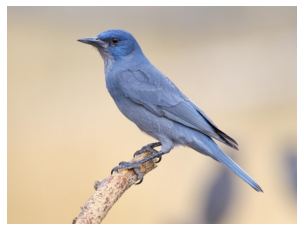

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.axis("off"); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/> since we need a batch dimension while passing it to the models.

In [23]:
# Apply the transformations needed
from torchvision import transforms
trf = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`transforms.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `transforms.Resize(256)` : Resizes the image to size `256 x 256`
- `transforms.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `transforms.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `transforms.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

Now that we have the image all preprocessed and ready! Let's pass it through the model and get the `out` key.<br/>
Note that for these torchvision models, the output of the model is a `OrderedDict` and not a simple tensor as we normally have. So, we need to take the `out` key from that to get the output of the model.

In [24]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


So, `out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]` as discussed earlier. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

And how do we get there from this `[1 x 21 x H x W]`?<br/>
We take a max index for each pixel position, which represents the class<br/>

In [25]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


In [26]:
om

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

As we can see, now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [27]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list, 
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` 
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

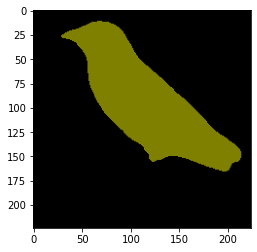

In [28]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

As we can see, the model correctly segments the bird.

Also, Do note that the image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Next, let's move all this under one function and play with a few more images!

In [29]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig:
    plt.imshow(img);
    plt.axis('off');
    plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = transforms.Compose([transforms.Resize(640), 
                   #T.CenterCrop(224), 
                   transforms.ToTensor(), 
                   transforms.Normalize(mean = [0.485, 0.456, 0.406],  std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

And let's get a new image!

2021-11-23 12:13:44 URL:https://cloudfront.horsenetwork.com/sites/4/2016/04/statue1.jpg [698695/698695] -> "horse.jpg" [1]


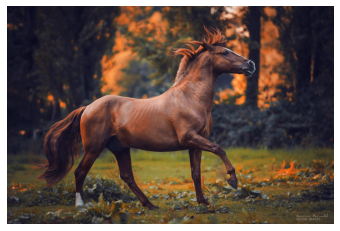

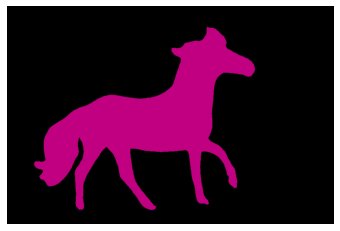

In [30]:
!wget -nv https://cloudfront.horsenetwork.com/sites/4/2016/04/statue1.jpg -O horse.jpg
segment(fcn, path='./horse.jpg')

2021-11-23 12:13:46 URL:https://miro.medium.com/max/4096/1*Qey6q3SCllXbSny1A1fSwA.jpeg [428014/428014] -> "cs-test.jpg" [1]


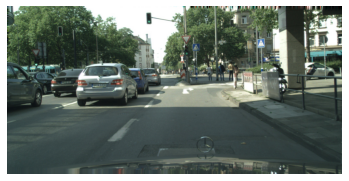

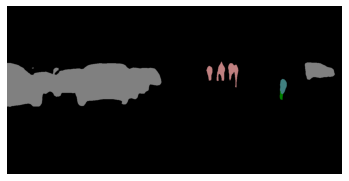

In [31]:
!wget -nv https://miro.medium.com/max/4096/1*Qey6q3SCllXbSny1A1fSwA.jpeg -O cs-test.jpg
segment(fcn, path='./cs-test.jpg')

### DeepLabv3

The model we've used above, altough it gives good results, is far from being the best availble model. Let's try Deeplabv2 which is a newer model.

In [32]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

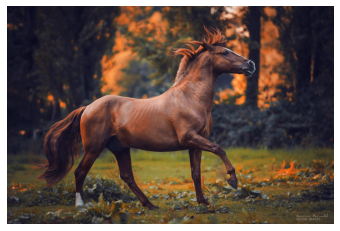

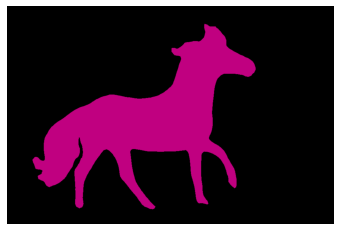

In [33]:
segment(dlab, './horse.jpg')

As you can see that, the DeepLab model has also classified the image quite nicely! </br>
But if we take a more complex image! Then we start to see the differences!

2021-11-23 12:13:51 URL:https://farm5.staticflickr.com/4116/4929366741_1455cde61f_z.jpg [104199] -> "complex.jpg" [1]


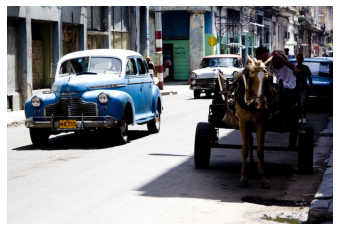

Segmenatation Image on FCN


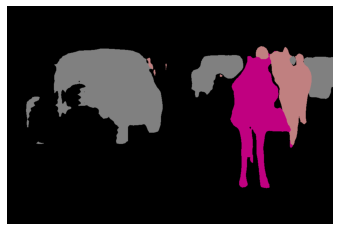

Segmenatation Image on DeepLabv3


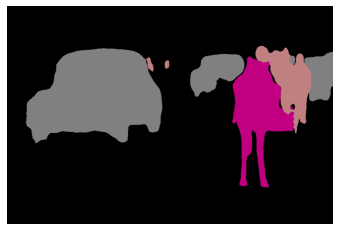

In [34]:
!wget -nv "https://farm5.staticflickr.com/4116/4929366741_1455cde61f_z.jpg" -O complex.jpg
img = Image.open('./complex.jpg')
plt.imshow(img); plt.axis('off'); plt.show(); 

print ('Segmenatation Image on FCN')
segment(fcn, path='./complex.jpg', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./complex.jpg', show_orig=False)

Now, we can see how FCN fails to capture the continuity of the car while DeepLabv3 is able to capture that!

### Comparision

For, now we will see how these two models compare with each other in 3 metrics
- Inference time
- Size of the model
- GPU memory used by the model

#### Inference Time

In [35]:
import time

def infer_time(net, path='./horse.jpg', dev='cuda'):
  img = Image.open(path)
  trf = transforms.Compose([transforms.Resize(256), 
                   transforms.CenterCrop(224), 
                   transforms.ToTensor(), 
                   transforms.Normalize(mean = [0.485, 0.456, 0.406],  std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

**On CPU**

In [36]:
avg_over = 50

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [1.659651279449463, 1.4620566368103027, 1.474130392074585, 1.4558732509613037, 1.4347198009490967, 1.445662260055542, 1.4272732734680176, 1.4343161582946777, 1.4367427825927734, 1.4355554580688477]
Inference time for first few calls for DeepLabv3: [1.8292057514190674, 1.7419307231903076, 1.721606731414795, 1.7211551666259766, 1.7426960468292236, 1.7234013080596924, 1.7277061939239502, 1.7263939380645752, 1.7041151523590088, 1.7008228302001953]
The Average Inference time on FCN is:     1.44s
The Average Inference time on DeepLab is: 1.72s


**On GPU**

In [37]:
avg_over = 50

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_gpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_gpu[:10]))

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

Inference time for first few calls for FCN      : [0.09793901443481445, 0.027607440948486328, 0.02808523178100586, 0.027109384536743164, 0.025328874588012695, 0.02527928352355957, 0.028641700744628906, 0.027965068817138672, 0.02695631980895996, 0.026222705841064453]
Inference time for first few calls for DeepLabv3: [0.10036611557006836, 0.03071880340576172, 0.0291750431060791, 0.02862834930419922, 0.028437376022338867, 0.028902769088745117, 0.02795553207397461, 0.03137969970703125, 0.030104637145996094, 0.02814626693725586]
The Average Inference time on FCN is:     0.029s
The Average Inference time on DeepLab is: 0.031s



We can see that in both cases (for GPU and CPU) its taking longer for the DeepLabv3 model, as its a much deeper model as compared to FCN.

Also, we have printed out the first few inference times for each model. Something we can notice is that the inference time for the first call
takes quite long than the others . This is because after the 1st call a lot of the calculations required are cached and thus its faster for the next calls.

Nice! Now, let's try to vizualize the difference in the time taken for the CPU and the GPU.

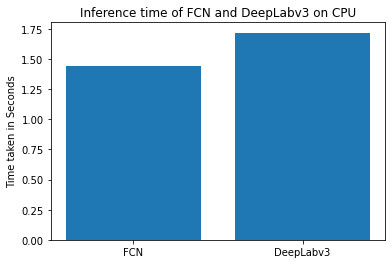

In [38]:
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()

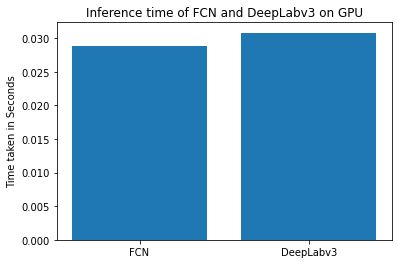

In [39]:
plt.bar([0.1, 0.2], [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on GPU')
plt.show()

Okay! Now, let's move on to the next comparison, where we will compare the model sizes for both the models.

#### Model Size

In [45]:
import os

resnet101 = torch.save(models.resnet101(pretrained=True).eval(), '/root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth')

resnet101_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth')
fcn_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth')
dlab_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth')

fcn_total = fcn_size + resnet101_size
dlab_total = dlab_size + resnet101_size
    
print ('Size of the FCN model with Resnet101 backbone is:       {:.2f} MB'.format(fcn_total /  (1024 * 1024)))
print ('Size of the DeepLabv3 model with Resnet101 backbone is: {:.2f} MB'.format(dlab_total / (1024 * 1024)))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Size of the FCN model with Resnet101 backbone is:       378.27 MB
Size of the DeepLabv3 model with Resnet101 backbone is: 403.78 MB


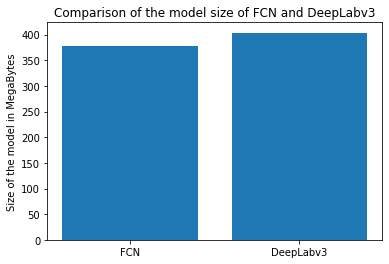

In [46]:
plt.bar([0, 1], [fcn_total / (1024 * 1024), dlab_total / (1024 * 1024)])
plt.ylabel('Size of the model in MegaBytes')
plt.xticks([0, 1], ['FCN', 'DeepLabv3'])
plt.title('Comparison of the model size of FCN and DeepLabv3')
plt.show()

So the cost of using better models is quite significant, in terms of both memort and computation. So we need to use them only if needed and for the corresponding tasks.

## Training from scratch

Until now, we only used the pretrained models from torch vision. Now, we'll get a but deeper and create and train our own model (note: this is based on https://github.com/milesial/Pytorch-UNet and https://github.com/usuyama/pytorch-unet)

To keep things simple, we simply train on synthetic data, but this does not change the process to go through, and the same will be applicable for real datasets. The data we'll create consists of 6 shapes that are randomly placed in the image, and each shape is its own class. So 6 classes.

In [ ]:
!wget -nv "https://raw.githubusercontent.com/usuyama/pytorch-unet/master/simulation.py" -O simulation.py


In [ ]:
!wget -nv "https://raw.githubusercontent.com/usuyama/pytorch-unet/master/helper.py" -O utils.py

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import simulation
from utils import masks_to_colorimg

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

In [ ]:
from utils import plot_side_by_side
plot_side_by_side([input_images_rgb, target_masks_rgb])

As we can see, the data is very simple. The inputs are black and weight images on the left, and the outputs are the segmentation target on right, where each shape has a specific class.

### Prepare Dataset and DataLoader

As we've done earlier, we need to apply the preprocessing steps (croping, resizing, nomalizing, and creating batches of data). Here we'll only transform the image to a tensor and normalize it since we already control the size when creating the dataset. This is done inside our dataset classe, which is then used to create our dataloader.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
  def __init__(self, count, transform=None):
    # here we create our synthetic dataset
    self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
    self.transform = transform

  def __len__(self):
    # number of instances in our dataset
    return len(self.input_images)

  def __getitem__(self, idx):
    # for each iteration, we return the trasformed image and its mask
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

In [ ]:
# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

#### Check the outputs from DataLoader

We always need to check everything is correct at each step of the way. So now, let's create an instance of the datalader, fetch some data, and see if everything is good. Note that to vizualize the images, we need to do an inverse transform. Add the mean, multiply by the standard deviation, and go from a range of [0, 1] to [0, 255].

In [ ]:
import torchvision.utils

def reverse_transform(inp):
  # inverse of the transformation we did in the dataset
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

# print the shapes
print(inputs.shape, masks.shape)

# see the input images
plt.imshow(reverse_transform(inputs[3]))

### Creating the Model

Now that the data is ready, we need our model. In this lab, we'll use Unet. Unet is a very successful model and by implementing it, we can get a better understading on the inner workings of other models.

Now first, let's take a look into the models structure:

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

As we've seen during the lecture. The model consits of an encoder (the left par). And the decoder (the right part).

Now to create a model, we can see that in both the encoder and the decoder, we have repeating patterns. In the encoder, each time we apply two conv3x3 - relu, then max pool. And in the decoder, each time an upconv (or a deconvolution), a concatenation with the upcomping activations from the skip connections and two conv3x3 and relu. Let's create these modules.

#### Unet Parts

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def TwoConv(in_channels, out_channels):
  return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = TwoConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # padding is used to maintain the same spatial dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.conv = TwoConv(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.maxpool(x))


Now with the two modules, we can create our unet model. The model takes as input the input channels (RGB for color images or 1 for back and weight images), and also the number of output classes (7 in our case)

#### Model creation

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_classes, n_channels=3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = TwoConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#### Model Initiation

In [ ]:
device = torch.device('cuda')
print('device', device)

assert torch.cuda.is_available(), "GPU not availalbe. CPU training will be too slow. Please activate the GPU."

model = UNet(6)
model = model.to(device)

Now let's do a simple test to see if everything is correct.

In [ ]:
input_test = torch.randn(10, 3, 224, 224)
input_test = input_test.cuda()

output = model(input_test)
assert output.shape[0] == 10
assert output.shape[1] == 6
assert output.shape[2] == 224
assert output.shape[3] == 224

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

### Training loop.

The last step is to define the training loop. When we fetch the data, pass them through the model to get the predictions. Compute the loss. And optimize the model.

In [ ]:
from collections import defaultdict
import torch.nn.functional as F

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics):
    loss = F.binary_cross_entropy_with_logits(pred, target)

    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

Now let's launch the training process.

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 6
model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

### Testing

Now that the models is trained, let's test it on new images.

In [ ]:
import math

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

And the results are as follows (Left: Input - Middle: Ground truth- Right: Prediction)

In [ ]:
plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

As we can see, the model is very close to the correct predcition, but does make some mistakes like the edges of the square. With more training, we expect the model to do better given the simplicity of the task.

## Your turn.

Now it is your turn.

- We only used a very simple datasets. You are tasked to train UNet model followign the same step with some adjustments (dataset, training setting ...). Use a small version of cityscpaes dataset called: minicity_dataset
 - Link: https://drive.google.com/file/d/1YjkiaLqU1l9jVCVslrZpip4YsCHHlbNA/view

 - Implement other models.
  - PSPNet: https://arxiv.org/abs/1612.01105
  - Segnet:https://arxiv.org/pdf/1511.00561.pdf

  Good luck.